# Setup

In [1]:
!pip install -U transformers
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
import zipfile
import matplotlib.pyplot as plt
from sklearn import metrics

# Load dev data set

In [3]:
TEST_FILE = "dev.csv"
test_corpus = pd.read_csv(TEST_FILE, encoding='utf-8')
test_labels = np.array(test_corpus['label'])

# Load Models

Unzip model file and load

In [4]:
with zipfile.ZipFile('LSTM_MODEL.zip', 'r') as zip_ref:
    zip_ref.extractall('LSTM_MODEL')

LSTM_MODEL = tf.keras.models.load_model("LSTM_MODEL/content/AV_LSTM_MODEL")

#Prepare data

Case fold data and concatenate pairs with [SEP] token

In [5]:
# Case fold each text
def preprocess(string):
  output = str(string).lower()
  return output

# Prepare data for Distilled Bert
def prepare_data(data) :
  data["text_1"] = data["text_1"].apply(lambda x: preprocess(x))
  data["text_2"] = data["text_2"].apply(lambda x: preprocess(x))
  concat_pairs = []
  for index, row in data.iterrows():
      concatenated_pair = row["text_1"] + " [SEP] " + row["text_2"]
      concat_pairs.append(concatenated_pair)
  return concat_pairs

concat_data = prepare_data(test_corpus)

Load pre-trained BERT models

In [6]:
tokeniser = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Create BERT embeddings

In [7]:
SEQ_LENGTH = 256
BATCH_SIZE = 32
def create_bert_embeddings_batch(texts, tokeniser, model, batch_size, seq_length) :
  embeddings = []
  for i in range(0, len(texts), batch_size) :
    batch = texts[i:i + batch_size]
    inputs = tokeniser.batch_encode_plus(batch, padding='max_length', truncation=True, return_tensors='tf', max_length=seq_length)

    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

    last_hidden_state_CLS = outputs.last_hidden_state[:, 0, :]

    embeddings.append(last_hidden_state_CLS)
  return embeddings

bert_embeddings = create_bert_embeddings_batch(concat_data, tokeniser, bert_model, BATCH_SIZE, SEQ_LENGTH)

# Test Models

Re-format inputs and predict labels

In [8]:
test_inputs = np.concatenate(bert_embeddings, axis=0)
print(test_inputs.shape)
predictions = LSTM_MODEL.predict(test_inputs)
binary_predictions = (predictions >= 0.5).astype(int)

(6000, 768)
188/188 [==============================] - 16s 22ms/step


# Save predictions

Save predictions to csv file

In [9]:
predictions_DF = pd.DataFrame(binary_predictions, columns=['prediction'])
predictions_DF.to_csv('Group_26_B.csv', index=False)

# Generate Metrics

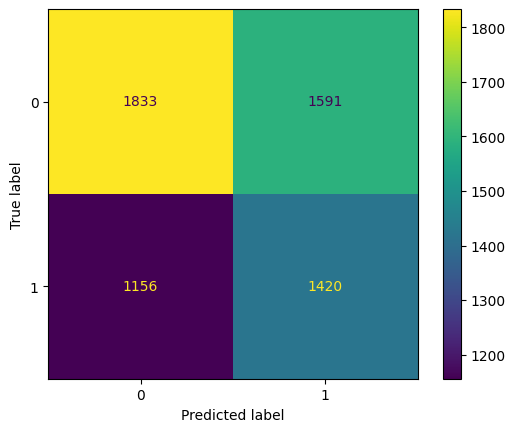

Accuracy: 54.21666666666667
Precision:  55.12422360248447
Recall:  47.16041182331451
F-score:  50.832289242885274


In [12]:
# Transpose binary predictions for comparison
binary_predictions_T = np.transpose(binary_predictions)
num_predictions = len(binary_predictions)

# Find tp, fp, tn, fn
true_positives = np.sum(np.logical_and(binary_predictions_T == 1, test_labels == 1))
false_positives = np.sum(np.logical_and(binary_predictions_T == 1, test_labels == 0))
true_negatives = np.sum(np.logical_and(binary_predictions_T == 0, test_labels == 0))
false_negatives = np.sum(np.logical_and(binary_predictions_T == 0, test_labels == 1))

# Calculate metrics
accuracy = (true_positives + true_negatives) / num_predictions
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Generate confusion matrix

confusion_matrix = metrics.confusion_matrix(binary_predictions_T.flatten(), test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Accuracy:", accuracy * 100)
print("Precision: ", precision * 100)
print("Recall: ", recall * 100)
print("F-score: ", f_score * 100)